## Part 1 : Manual Bipartition of the Original Graph

First of all, we should import the necessary libraries.

In [19]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Then, using NetworkX we shall load the dataset.

In [2]:
G = nx.karate_club_graph()
print(G)    # gives a short summary of our graph

Graph named "Zachary's Karate Club" with 34 nodes and 78 edges


We need to extract the Adjacency matrix 'A', the degree vector 'k' & number of edges 'm' from this graph.
<br>However, before that we should create a separate fixed list of nodes for consistent ordering.

In [3]:
node_list = list(G.nodes())
n = len(node_list)    # no. of nodes

A = nx.to_numpy_array(G, nodelist=node_list)

k = np.array([G.degree(node) for node in node_list]).reshape(n,1)
# list comprehension to ensure order of nodes is same as in node_list.

m = G.number_of_edges()

print("Adjacency Matrix A:\n", A)
print("\nDegree Vector k:\n", k)
print("\nTotal Edges m:", m)

Adjacency Matrix A:
 [[0. 4. 5. ... 2. 0. 0.]
 [4. 0. 6. ... 0. 0. 0.]
 [5. 6. 0. ... 0. 2. 0.]
 ...
 [2. 0. 0. ... 0. 4. 4.]
 [0. 0. 2. ... 4. 0. 5.]
 [0. 0. 0. ... 4. 5. 0.]]

Degree Vector k:
 [[16]
 [ 9]
 [10]
 [ 6]
 [ 3]
 [ 4]
 [ 4]
 [ 4]
 [ 5]
 [ 2]
 [ 3]
 [ 1]
 [ 2]
 [ 5]
 [ 2]
 [ 2]
 [ 2]
 [ 2]
 [ 2]
 [ 3]
 [ 2]
 [ 2]
 [ 2]
 [ 5]
 [ 3]
 [ 3]
 [ 2]
 [ 4]
 [ 3]
 [ 4]
 [ 4]
 [ 6]
 [12]
 [17]]

Total Edges m: 78


Now, we must compute our Modularity Matrix $B$.

We know that $$B = A - \frac{k k^T}{2m}$$

In [4]:
B = A - (k @ k.T) / (2*m)
print(B)

[[-1.64102564  3.07692308  3.97435897 ...  1.38461538 -1.23076923
  -1.74358974]
 [ 3.07692308 -0.51923077  5.42307692 ... -0.34615385 -0.69230769
  -0.98076923]
 [ 3.97435897  5.42307692 -0.64102564 ... -0.38461538  1.23076923
  -1.08974359]
 ...
 [ 1.38461538 -0.34615385 -0.38461538 ... -0.23076923  3.53846154
   3.34615385]
 [-1.23076923 -0.69230769  1.23076923 ...  3.53846154 -0.92307692
   3.69230769]
 [-1.74358974 -0.98076923 -1.08974359 ...  3.34615385  3.69230769
  -1.8525641 ]]


We define a Modularity Score $Q$.
$$Q = \frac{s^T B s}{4m}$$

...(where $s$ is our label vector that assigns a +/- 1 label to each node, corresponding to it's community)

We need to maximise $Q$, which means that we must maximise $s^T B s$.
Since going through all possible combinations of $s$ is not realistically possible, we use a trick in optimization.

We relax $s$, such that $\|s\|_2 = 1$, this leads us to a standard result in linear algebra that tells us that   
$s^T B s$ is maximised when $s$ is the eigenvector of $B$ corresponding to the highest eigenvalue.   

Therefore, now our problem is reduced to finding the eigenvector of $B$

In [5]:
# Compute the eigenvalues and eigenvectors of B
eigenvalues, eigenvectors = np.linalg.eigh(B)

index_max_eigenvalue = np.argmax(eigenvalues)

lambda_1 = eigenvalues[index_max_eigenvalue]
u_1 = eigenvectors[:, index_max_eigenvalue]    # Eigenvectors are columns in the eigenvectors matrix

print("Largest Eigenvalue (λ₁):", lambda_1)
print("\nLeading Eigenvector (u₁):\n", u_1)

Largest Eigenvalue (λ₁): 17.107386763280683

Leading Eigenvector (u₁):
 [-0.32365173 -0.32525797 -0.26399012 -0.2423719  -0.08231957 -0.10763723
 -0.10534045 -0.21899159  0.04046967  0.02468171 -0.07180498 -0.05697514
 -0.06185916 -0.18088488  0.09998153  0.1405319  -0.03778568 -0.05728769
  0.06006922 -0.05624387  0.07970634 -0.07630041  0.10030056  0.29584494
  0.06714587  0.17810773  0.08482204  0.13031193  0.03315935  0.19121343
  0.08889084  0.20638044  0.34139764  0.34685546]


Now, we have gotten $u_1$ in the form of a soft assignment. So we must convert it into a hard assignment by splitting the nodes into 2 communities based on sign of each element of $u_1$.

In [6]:
node_array = np.array(node_list)

community1 = node_array[u_1 > 0].tolist()
community2 = node_array[u_1 <= 0].tolist()

print("Community 1:", community1)
print("Community 2:", community2)

Community 1: [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Community 2: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]


Now that we've split the graph into 2 communities, we must visualise this split.

In [9]:
# Function for visualising communities in any graph

def visualise_communities(G, pos, communities, title=""):
    """Draws the graph with nodes colored by their community."""    #docstring
    
    plt.figure(figsize=(10, 8))
    
    node_color_map = {}
    colors = ['skyblue', 'salmon', 'lightgreen', 'gold', 'violet', 'orange', 'lightgray']
    
    for i, community in enumerate(communities):
        for node in community:
            node_color_map[node] = colors[i % len(colors)] # Cycle through colors
            
    # Create a list of colors in the correct order for drawing
    node_colors = [node_color_map.get(node, 'lightgray') for node in G.nodes()]

    # Draw the graph using the fixed positions
    nx.draw(G, 
            pos=pos,
            with_labels=True,
            node_color=node_colors,
            node_size=500,
            font_color='black'
           )
    
    plt.title(title, fontsize=16)
    plt.show()

--- Visualising the first two-way split ---


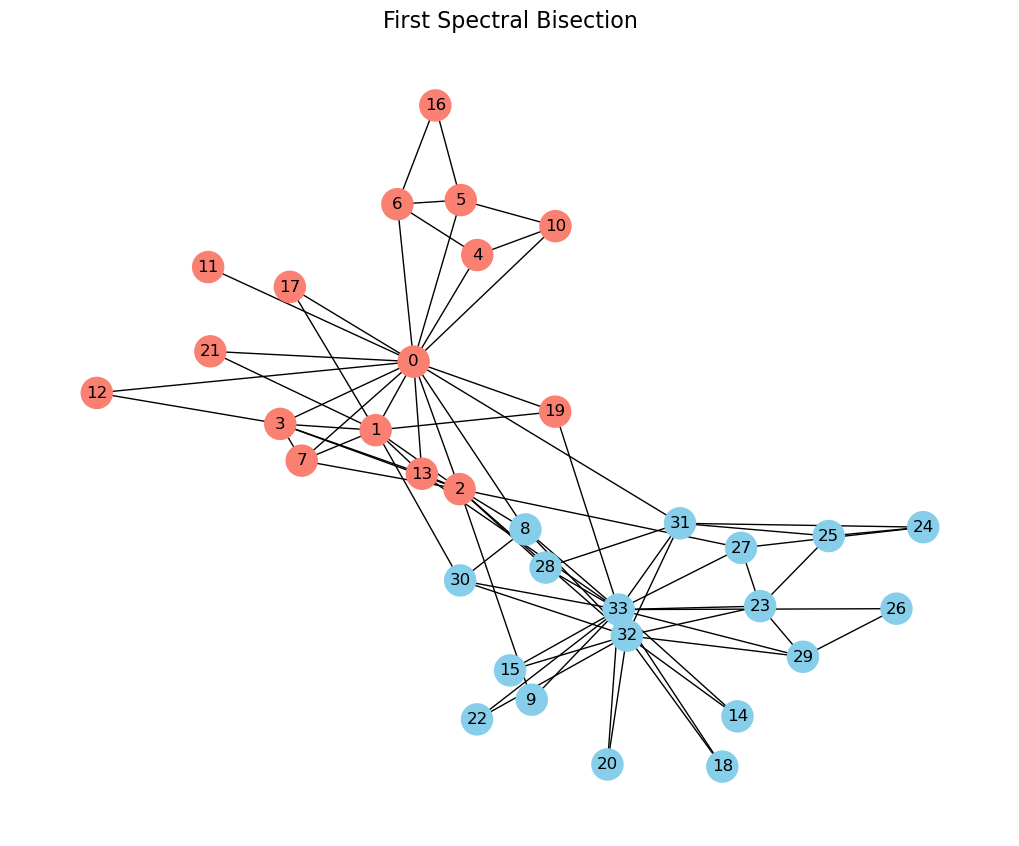

In [12]:
# --- Visualise the First Manual Split ---

# create the fixed layout positions
pos = nx.spring_layout(G, seed=42)

# call the visualisation function with the two communities we've found
print("--- Visualising the first two-way split ---")
visualise_communities(G, pos, [community1, community2], "First Spectral Bisection")

This is how our Karate Club would've been split into two communities.

One following *the club president*, the other following *Mr. Hi*.

---
## Part 2 : Iterative Algorithm to Detect All Communities

Now, let's automate this process to find if there are multiple communities in our graph.

In [26]:
# 1. Helper function to test and perform a single split
def find_split(G_original, community_nodes, original_m):
    """
    Tests if a community can be split.
    If yes, returns the two new communities. If no, returns None.
    """
    subgraph = G_original.subgraph(community_nodes)
    sub_nodelist = list(subgraph.nodes())
    
    # A community of 1 or 0 cannot be split.
    if len(sub_nodelist) <= 1:
        return None

    # Calculate the restricted modularity matrix B^(C) for the subgraph.
    # Degrees (k) must be from the original graph.
    sub_A = nx.to_numpy_array(subgraph, nodelist=sub_nodelist)
    original_degrees = [G_original.degree(node) for node in sub_nodelist]
    sub_k = np.array(original_degrees).reshape(len(sub_nodelist), 1)
    sub_B = sub_A - (sub_k @ sub_k.T) / (2 * original_m)

    # Find the leading eigenvalue (lambda_1).
    eigenvalues, eigenvectors = np.linalg.eigh(sub_B)
    lambda_1 = np.max(eigenvalues)
    
    # STOP if the leading eigenvalue is not meaningfully positive.
    # This tolerance check is the critical fix for the infinite loop.
    if lambda_1 < 1e-10:
        return None
        
    # SPLIT the community using the signs of the corresponding eigenvector.
    u_1 = eigenvectors[:, np.argmax(eigenvalues)]
    comm1 = [node for i, node in enumerate(sub_nodelist) if u_1[i] > 0]
    comm2 = [node for i, node in enumerate(sub_nodelist) if u_1[i] <= 0]
    
    # A split is only valid if it creates two non-empty groups.
    if not comm1 or not comm2:
        return None
        
    return comm1, comm2

--- Starting Iterative Community Detection ---
--- Iteration 0: 1 communities ---


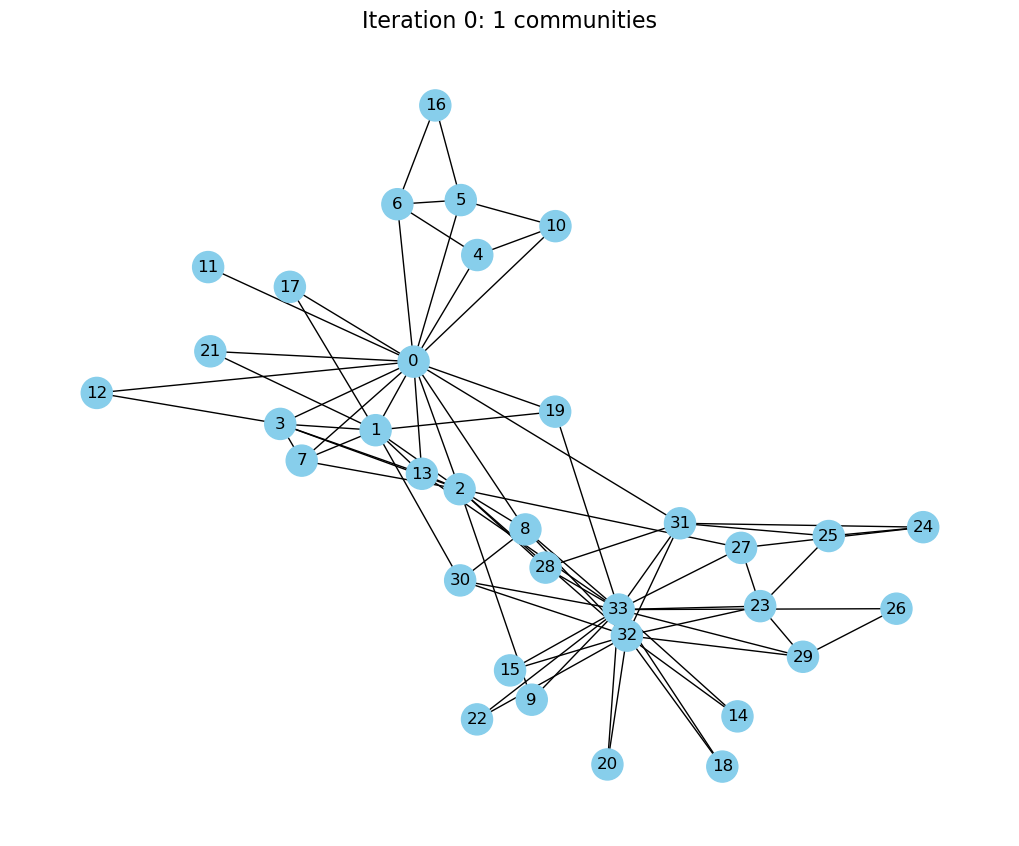

Calculating metrics for iteration 0...
Split community [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33] into:
  -> [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
  -> [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]
--- Iteration 1: 2 communities ---


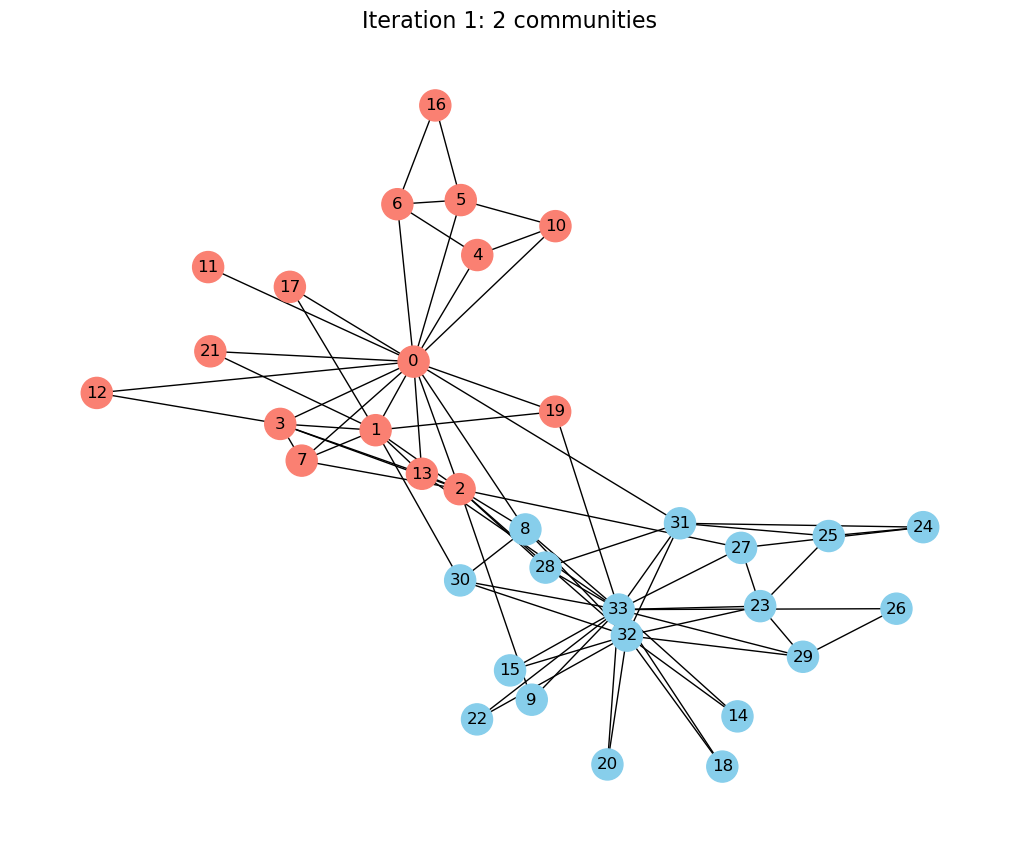

Calculating metrics for iteration 1...

No more splittable communities found. Halting.

--- Community Detection Finished ---
Final state: 2 communities found.
[[8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]]


In [27]:
# 2. Main Analysis Loop

# Initial setup
communities = [list(G.nodes())] # Start with one community: the whole graph
metrics_history = {}
iteration = 0

print("--- Starting Iterative Community Detection ---")

while True:
    # --- Task 2 & 3: Visualize and Record Metrics for the current state ---
    title = f"Iteration {iteration}: {len(communities)} communities"
    print(f"--- {title} ---")
    visualise_communities(G, pos, communities, title)
    
    print(f"Calculating metrics for iteration {iteration}...")
    iter_metrics = {'degree': {}, 'betweenness': {}, 'closeness': {}, 'clustering': {}}
    for community_nodes in communities:
        subgraph = G.subgraph(community_nodes)
        # Calculate metrics for nodes *within* their current subgraph
        deg_cen = nx.degree_centrality(subgraph)
        bet_cen = nx.betweenness_centrality(subgraph)
        clo_cen = nx.closeness_centrality(subgraph)
        clu_cen = nx.clustering(subgraph)
        for node in community_nodes:
            iter_metrics['degree'][node] = deg_cen.get(node, 0)
            iter_metrics['betweenness'][node] = bet_cen.get(node, 0)
            iter_metrics['closeness'][node] = clo_cen.get(node, 0)
            iter_metrics['clustering'][node] = clu_cen.get(node, 0)
    metrics_history[iteration] = iter_metrics
    
    # --- Task 1: Find and perform the next split ---
    
    # Find the largest community that is still splittable
    community_to_split = None
    split_result = None
    
    # We sort the communities by size to try splitting the largest ones first
    sorted_communities = sorted(communities, key=len, reverse=True)
    
    for community in sorted_communities:
        result = find_split(G, community, m)
        if result is not None:
            # We found a community we can split
            community_to_split = community
            split_result = result
            break # Stop searching and perform the split
            
    # --- Check if we should stop the loop ---
    if community_to_split is None:
        # If we went through all communities and none could be split, we're done.
        print("\nNo more splittable communities found. Halting.")
        break
    
    # --- If we found a split, update the list of communities ---
    new_comm1, new_comm2 = split_result
    communities.remove(community_to_split)
    communities.append(new_comm1)
    communities.append(new_comm2)
    
    print(f"Split community {community_to_split} into:\n  -> {new_comm1}\n  -> {new_comm2}")
    
    iteration += 1

# --- Final State ---
print("\n--- Community Detection Finished ---")
print(f"Final state: {len(communities)} communities found.")
print(communities)

Thus, we found that our Karate Club graph can only be split into 2 communities such that the modularity score doesn't decrease.

---
## Part 3 : Metric Evolution and Final Discussion

Finally, we need to show how each node's metrics evolve across successive iterations.

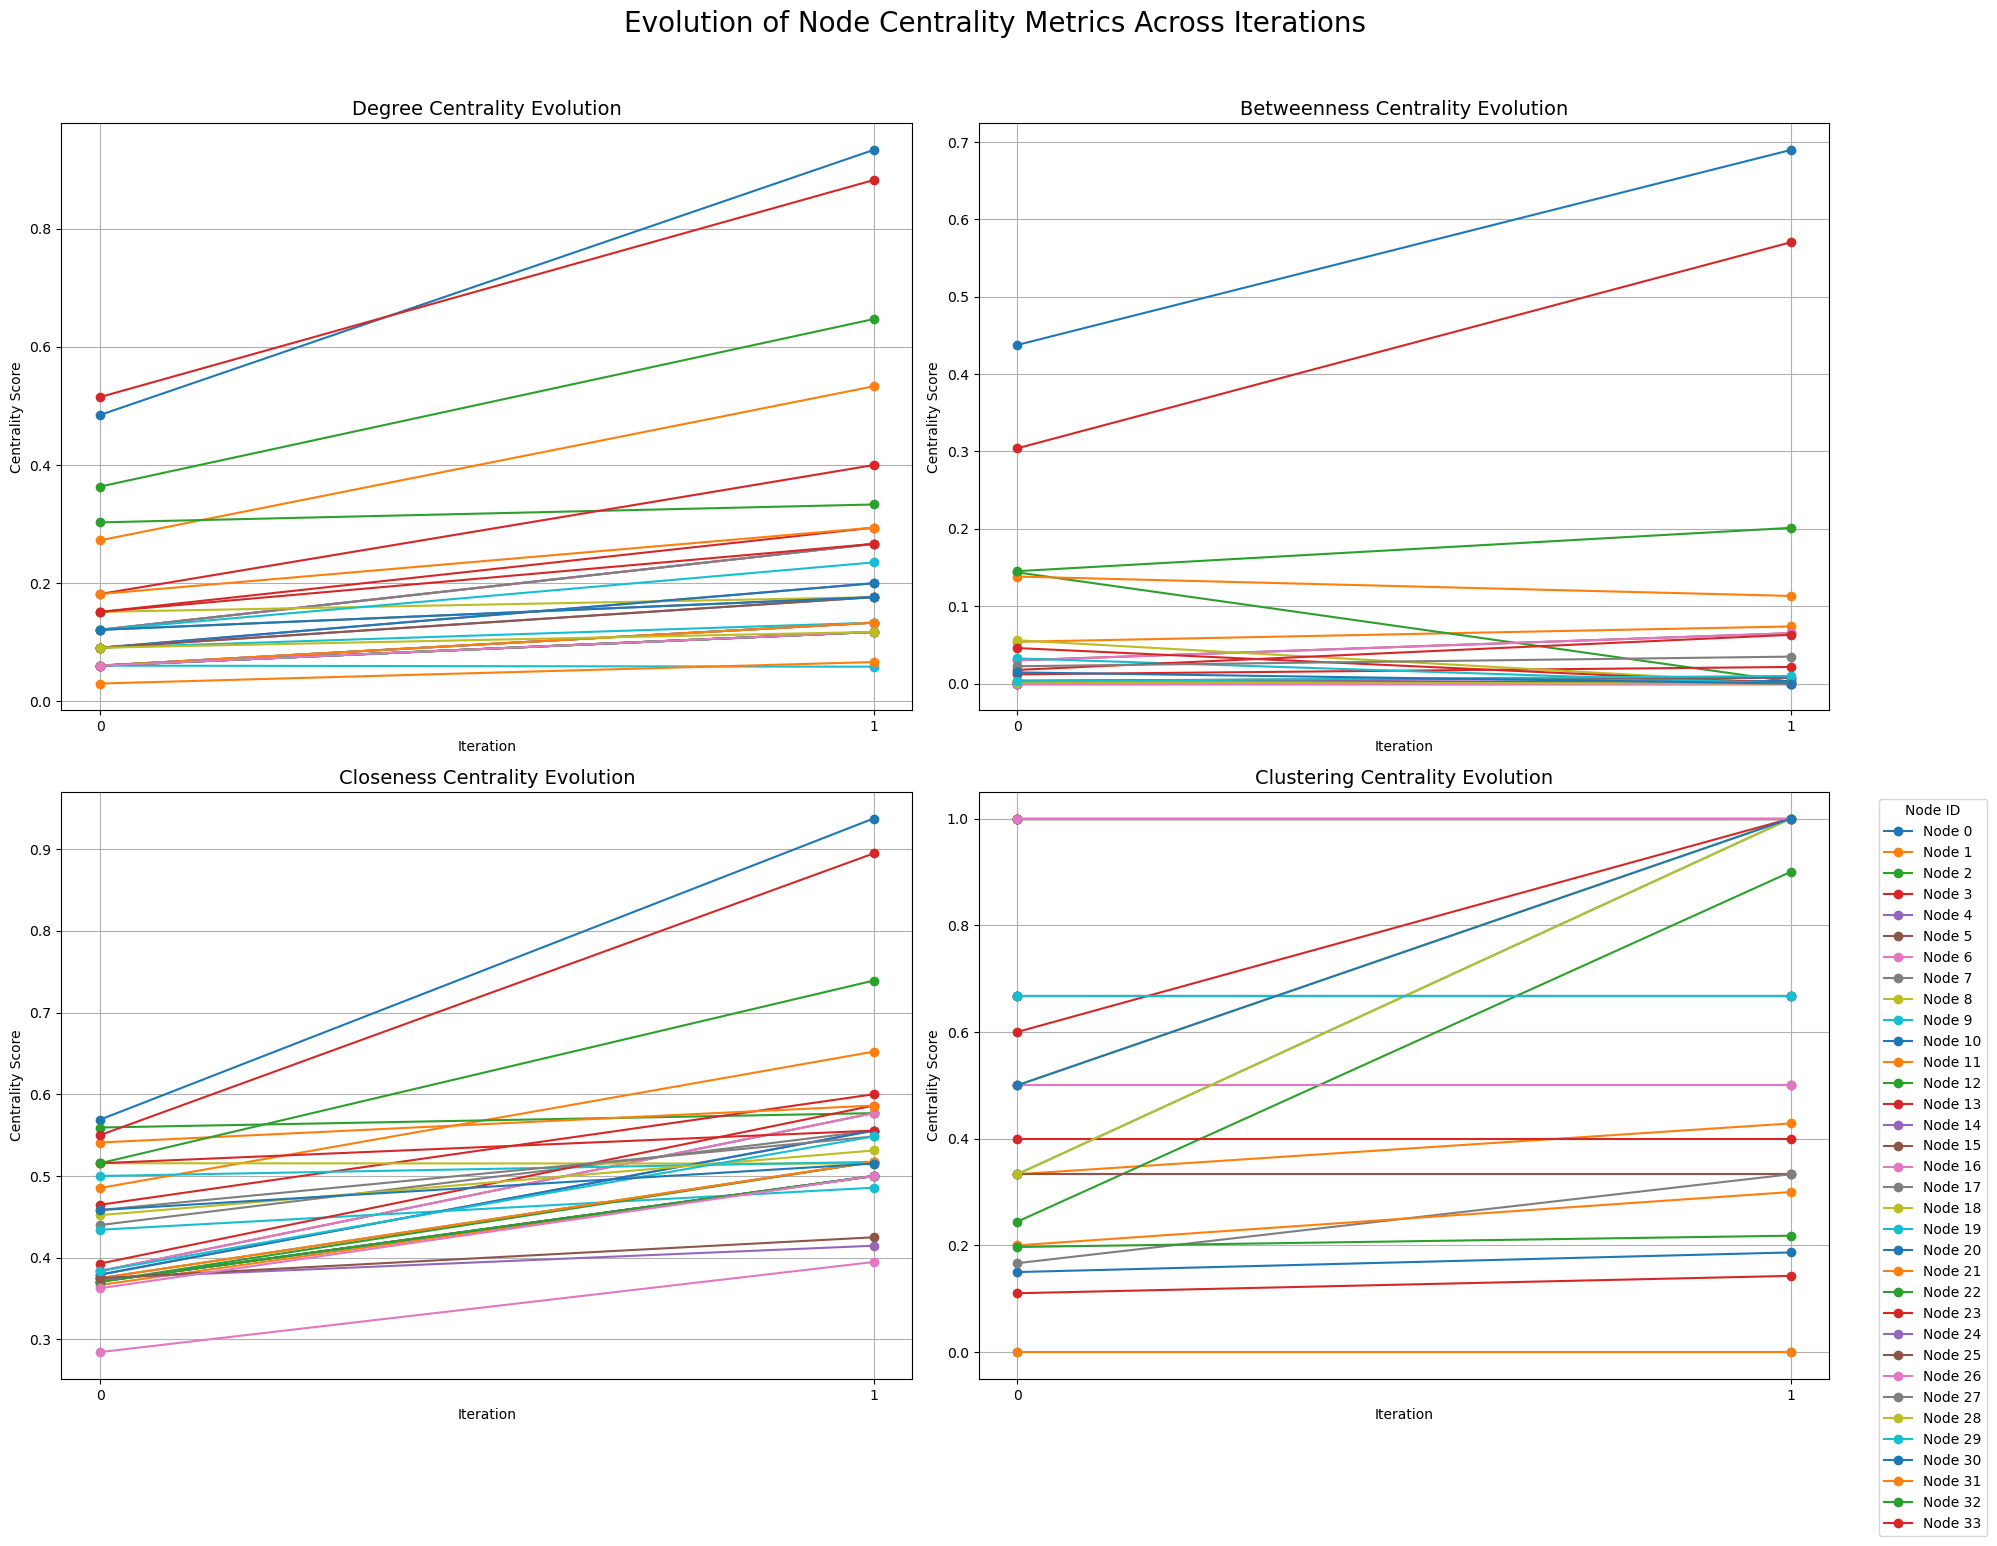

In [28]:
# Create a figure to hold all four of our plots
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Evolution of Node Centrality Metrics Across Iterations', fontsize=20)

# We can flatten the 2x2 grid of plots into a single list to loop through it easily
axes = axes.flatten()

# List of the metrics we stored in our dictionary
metric_names = ['degree', 'betweenness', 'closeness', 'clustering']

for i, metric_name in enumerate(metric_names):
    
    # 1. Convert the data for the current metric into a pandas DataFrame.
    metric_df = pd.DataFrame({
        iteration: data[metric_name] 
        for iteration, data in metrics_history.items()
    })
    
    # 2. Plot the evolution for each node on the current subplot (axes[i])
    for node in metric_df.index:
        axes[i].plot(metric_df.columns, metric_df.loc[node], marker='o', linestyle='-', label=f'Node {node}')
    
    # 3. Add titles and labels to make the plot clear
    axes[i].set_title(f'{metric_name.capitalize()} Centrality Evolution', fontsize=14)
    axes[i].set_xlabel('Iteration')
    axes[i].set_ylabel('Centrality Score')
    axes[i].grid(True)
    
    # Ensure the x-axis only shows integer iteration numbers
    axes[i].set_xticks(list(metrics_history.keys()))

# To avoid a cluttered legend, we'll just add one to the last plot
axes[-1].legend(title='Node ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust the layout to make sure nothing overlaps
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The above plots describe our analysis of how the node centrality scores evolve as the network is split into two communities.

### Final Discussion

**Which nodes consistently remain central across splits?**

The nodes that consistently remain the most central across the split are Node 0 (blue) and Node 33 (maroon).   
Node 0 is the dominant central node, likely representing the instructor, Mr. Hi.   
Node 33 is the second most central, likely representing the other leader, the club president.   
The consistent top ranking in Betweenness Centrality is particularly important for these nodes, as it shows they are critical *bridges* for their factions, even after the community splits.

  **How does community structure influence these metrics?**

After the split, we see a general *increase* in all the centrality metrics. This happens because as the nodes get divided into two smaller, tightly-knit clusters, the tend to become more central to their own faction.

Degree & Closeness Centrality (Top & Bottom Left respectively)-
* We see that these scores have *increased* for most nodes.
* This is because after the split, as nodes were grouped into smaller communities, they would become more *central* to that smaller community as compared to the whole graph before.

Betweenness Centrality (Top Right)-
* Here, we see that for some nodes, this score drops after the graph is split.
* This is because after the split, the nodes that acted as *bridges* connecting the two eventual communities now no longer act as a bridge within their own communities.
* On the other hand, some nodes that now act as bridges in their own communities will see their score rising post-split.

Clustering Coefficient (Bottom Right)-
* In this plot, we see that the clustering coefficient shoots up for many points with some even reaching a score of 1.
* This means that our algorithm has succesfully partitioned the original graph into tightly-knit communities.

### Thank you for reading this notebook
>*-Aditya Narvekar, IMS24010, IISER TVM*

### Citation

Newman (2006), “Modularity and community structure in networks,” PNAS 103(23):8577–8582.